# Smart Trash Sorter – MobileNetV3 Demo

This notebook implements a **Smart Trash Sorter** demo based on my project proposal:

- Technique: *Image classification*
- Model: **MobileNetV3Small** (pre-trained on ImageNet)
- Framework: **TensorFlow / Keras**




In [1]:
# 1. Install required libraries (TensorFlow, etc.)
!pip -q install tensorflow matplotlib pillow scikit-learn


In [2]:
# 2. Imports and basic configuration (Fixed imports)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)

# Image settings
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32



TensorFlow version: 2.19.0


In [3]:
# 3*. Download trash dataset from Roboflow (one-time setup)

!pip -q install roboflow

from roboflow import Roboflow
import os, shutil

# >>> Replace these 4 lines with the code snippet from Roboflow <<<
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="n87AjKXMOoPqyIuwvfzR")
project = rf.workspace("ipcvhome-xeunk").project("waste-yfe9a")
version = project.version(2)
dataset = version.download("folder")


# dataset.location is the downloaded folder path (e.g. 'waste-classification-1')
print("Roboflow dataset downloaded to:", dataset.location)

# Rename / move to 'trash_data'
src = dataset.location
dst = "trash_data"

if os.path.exists(dst):
    print(f'"{dst}" already exists, keeping existing folder.')
else:
    shutil.move(src, dst)
    print(f'Moved dataset to "{dst}"')

# show subfolders (= class names) if needed
print("Class folders in trash_data/:", os.listdir(dst))


loading Roboflow workspace...
loading Roboflow project...
Roboflow dataset downloaded to: /content/Waste-2
"trash_data" already exists, keeping existing folder.
Class folders in trash_data/: ['train', 'valid', 'test', 'README.roboflow.txt', 'README.dataset.txt']


In [4]:
# 3. Data loading for training

DATA_DIR = 'trash_data/train'

if os.path.exists(DATA_DIR):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2,
    )

    train_ds = datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        subset='training'
    )

    val_ds = datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        subset='validation'
    )

    # set CLASS_NAMES dynamically from the dataset
    CLASS_NAMES = list(train_ds.class_indices.keys())
    print("Detected classes:", CLASS_NAMES)
    print("Number of classes:", len(CLASS_NAMES))

else:
    print(f' Dataset directory \"{DATA_DIR}\" not found. '
          'We can still use the prediction demo with an (untrained) model or a pre-saved model file.')



Found 560 images belonging to 6 classes.
Found 137 images belonging to 6 classes.
Detected classes: ['CardboardBoxes', 'GlassBottles', 'GlassJars', 'Laptops', 'Phones', 'PlasticBottles']
Number of classes: 6


In [5]:
# 4. Define MobileNetV3-based model
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze convolutional base for transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,750 (3.87 MB)

 Trainable params: 74,630 (291.52 KB)

 Non-trainable params: 939,120 (3.58 MB)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.1799 - loss: 1.8151

18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1803 - loss: 1.8140 - val_accuracy: 0.2482 - val_loss: 1.7355
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2494 - loss: 1.7319 - val_accuracy: 0.2482 - val_loss: 1.7260
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 993ms/step - accuracy: 0.2687 - loss: 1.7224 - val_accuracy: 0.2044 - val_loss: 1.7357
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2396 - loss: 1.7526 - val_accuracy: 0.2482 - val_loss: 1.7209


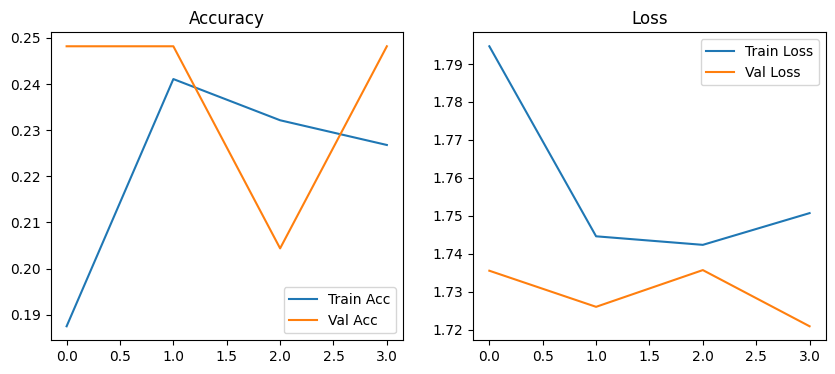

✅ Best model saved as smart_trash_mobilenetv3.h5


In [6]:
# 5. Train / fine-tune the model with callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 15  # increased epochs for better accuracy

if 'train_ds' in globals():
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    ckpt = ModelCheckpoint(
        'smart_trash_mobilenetv3.h5',
        monitor='val_accuracy',
        save_best_only=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stop, ckpt]
    )

    # Plot learning curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

    print(' Best model saved as smart_trash_mobilenetv3.h5')

else:
    print('No dataset loaded; skipping training.')


In [7]:
#  6. Use current trained model for inference (no reload)

# We just finished training `model` in this runtime, so we can use it directly.
infer_model = model
print("Using current in-memory trained model for inference.")


✅ Using current in-memory trained model for inference.


In [8]:
# 7. Helper function to classify a single image (Fixed to use tf.keras.utils.load_img)
def predict_image(path: str):
    """Load an image from disk, run it through the model, and print predictions."""
    img = load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    x = img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    preds = infer_model.predict(x)[0]
    top_idx = int(np.argmax(preds))
    top_label = CLASS_NAMES[top_idx]
    top_conf = float(preds[top_idx])

    print(f'Image: {path}')
    print(f'Prediction: {top_label} ({top_conf:.2%} confidence)')
    print('\nAll class probabilities:')
    for name, prob in zip(CLASS_NAMES, preds):
        print(f'{name:>8s}: {prob:.2%}')

    return top_label, top_conf, preds

print('Prediction helper ready.')


Prediction helper ready.


In [10]:
# 8A. Demo using a manual image path

test_image_path = 'test_bottle.jpg'  #

if os.path.exists(test_image_path):
    predict_image(test_image_path)
else:
    print(f' File {test_image_path} not found. Please change the path to an existing image file.')


⚠️ File test_bottle.jpg not found. Please change the path to an existing image file.


In [14]:
# 8B. Demo by uploading an image interactively – works in Google Colab
try:
    from google.colab import files
    uploaded = files.upload()
    for fname in uploaded.keys():
        print(f'Classifying uploaded file: {fname}')
        predict_image(fname)
except ImportError:
    print('google.colab not available in this environment; use the manual path demo instead (cell 8A).')


Saving plastic-bottles-waste-1.jpg to plastic-bottles-waste-1.jpg
Classifying uploaded file: plastic-bottles-waste-1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: plastic-bottles-waste-1.jpg
Prediction: GlassJars (23.31% confidence)

All class probabilities:
CardboardBoxes: 16.81%
GlassBottles: 17.57%
GlassJars: 23.31%
 Laptops: 9.29%
  Phones: 13.08%
PlasticBottles: 19.95%
